# FullyConnected on MNIST (Knowledge Distillation)

### Imports and Setup

In [1]:
# PyTorch and Models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR
from architectures.FullyConnected import FullyConnected
import numpy as np

# Helper functions
import datasets.datasets as datasets
from util.common import *
from util.trainer import distillation_training

import matplotlib.pyplot as plt

In [2]:
# Make PyTorch deterministic
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Data, Training and Test Sets

In [4]:
# Loading dataset into training, distillation, and test data
training_loader = datasets.mnist_training_loader(True)
dist_training_loader = datasets.mnist_training_loader(False)
test_loader = datasets.mnist_test_loader()

In [5]:
# Define different temperatures and label smoothing factors
smoothing_factors_student = [0, 0.15, 0.3, 0.45, 0.6, 0.75]
smoothing_factors_teacher = [0, 0.15, 0.3, 0.45, 0.6, 0.75]
temperatures_teacher = [1.0, 2.0, 4.0, 8.0, 12.0, 16.0]

### Distillation training loop

In [7]:
def train_distillation(teacher, student, device, training_loader, test_loader, epochs, beta, temperature):
    cross_entropy = nn.CrossEntropyLoss()
    loss = nn.MSELoss()
    train_loss = lambda outputs, labels, pred: (1-beta)*cross_entropy(outputs, labels) + beta*0.5*loss(pred,outputs)
    
    opt = optim.SGD(params=[
        {"params":student.linear1.parameters(), 'lr': 1},
        {"params":student.linear2.parameters(), 'lr': 1},
        {"params":student.linear3.parameters(), 'lr': 0.1}
        ], momentum=0.9, dampening=0.9)
    
    scheduler = LinearLR(opt, 1, 0, epochs)
    
    distillation_training(teacher, student, device, training_loader, test_loader, epochs, train_loss, opt, scheduler, temperature)


### Training Teacher with Label Smoothing

In [ ]:
for j, elem in enumerate(smoothing_factors_teacher):
    model = FullyConnected(1200, 0.5 if j == 0 else 0)
    model.train_model(device, training_loader, test_loader, elem, NUM_EPOCHS_FULLY_CONNECTED)
    torch.save(model.state_dict(), f"models/FC_MNIST_Distillation/FC_Teacher_Smoothing_{j}.pt")

### Training Student with Label Smoothing without Distillation

In [ ]:
for j, elem in enumerate(smoothing_factors_student):
    model = FullyConnected(800, 0)
    model.train_model(device, dist_training_loader, test_loader, elem, NUM_EPOCHS_FULLY_CONNECTED)
    torch.save(model.state_dict(), f"models/FC_MNIST_Distillation/FC_Student_Smoothing_{j}.pt")

### Training Student with Distillation (Temperature-scaled Teacher)

In [ ]:
for j, elem in enumerate(temperatures_teacher):
    model = FullyConnected(1200)
    model.load_state_dict(torch.load(f"models/FC_MNIST_Distillation/FC_Teacher_Smoothing_0.pt",map_location=device))
    model2 = FullyConnected(800, 0)
    
    train_distillation(model, model2, device, dist_training_loader, test_loader, NUM_EPOCHS_FULLY_CONNECTED, 0.6, elem)
    torch.save(model2.state_dict(), f"models/FC_MNIST_Distillation/FC_Distillation_Temperature_{j}.pt")

### Training Student with Distillation (Label-smoothed Teacher)

In [ ]:
for j, elem in enumerate(smoothing_factors_teacher):
    model = FullyConnected(1200, 0.5 if j == 0 else 0)
    model.load_state_dict(torch.load(f"models/FC_MNIST_Distillation/FC_Teacher_Smoothing_{j}.pt",map_location=device))
    model2 = FullyConnected(800, 0)
    
    train_distillation(model, model2, device, dist_training_loader, test_loader, NUM_EPOCHS_FULLY_CONNECTED, 0.6, 1)
    torch.save(model2.state_dict(), f"models/FC_MNIST_Distillation/FC_Distillation_Smoothing_{j}.pt")

## Visualize the accuracies

In [6]:
student = []
for j, elem in enumerate(smoothing_factors_student):
    model = FullyConnected(800)
    model.load_state_dict(torch.load(f"models/FC_MNIST_Distillation/FC_Student_Smoothing_{j}.pt", map_location=device))
    model.to(device)
    
    student.append([elem, compute_accuracy(model, test_loader, device).cpu()])

In [7]:
teacher = []
for j, elem in enumerate(smoothing_factors_teacher):
    model = FullyConnected(1200)
    model.load_state_dict(torch.load(f"models/FC_MNIST_Distillation/FC_Teacher_Smoothing_{j}.pt", map_location=device))
    model.to(device)
    
    teacher.append([elem, compute_accuracy(model, test_loader, device).cpu()])

In [8]:
distillation_temperature = []
for j, elem in enumerate(temperatures_teacher):
    model = FullyConnected(800)
    model.load_state_dict(torch.load(f"models/FC_MNIST_Distillation/FC_Distillation_Temperature_{j}.pt", map_location=device))
    model.to(device)
    
    model2 = FullyConnected(1200)
    model2.load_state_dict(torch.load(f"models/FC_MNIST_Distillation/FC_Teacher_Smoothing_0.pt", map_location=device))
    model2.to(device)
    
    distillation_temperature.append([calculate_gamma(model2, dist_training_loader, device, elem).cpu(), compute_accuracy(model, test_loader, device).cpu()])

In [9]:
distillation_smoothing = []
for j, elem in enumerate(smoothing_factors_teacher):
    model = FullyConnected(800)
    model.load_state_dict(torch.load(f"models/FC_MNIST_Distillation/FC_Distillation_Smoothing_{j}.pt", map_location=device))
    model.to(device)
    
    model2 = FullyConnected(1200)
    model2.load_state_dict(torch.load(f"models/FC_MNIST_Distillation/FC_Teacher_Smoothing_{j}.pt", map_location=device))
    model2.to(device)
    
    distillation_smoothing.append([calculate_gamma(model2, dist_training_loader, device, 1).cpu(), compute_accuracy(model, test_loader, device).cpu()])

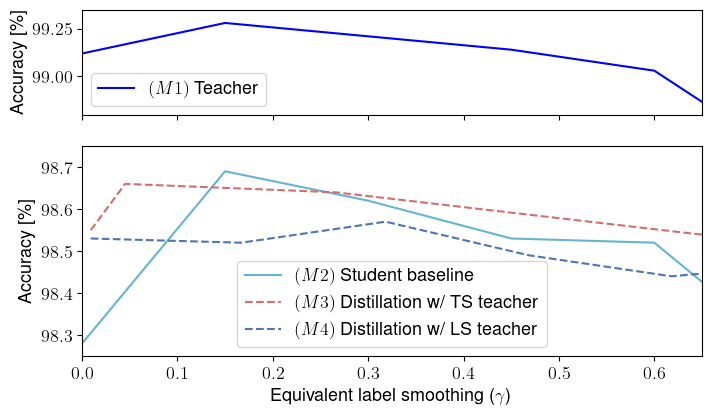

In [10]:
# Plot the accuracies
teacher = np.array(teacher)
student = np.array(student)
distillation_temperature = np.array(distillation_temperature)
distillation_smoothing = np.array(distillation_smoothing)

plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 13

fig, axs = plt.subplots(2,1,figsize=(8,4.5), gridspec_kw={'height_ratios': [1, 2]})

plt.setp(axs[0], xticklabels=[])

axs[0].plot(teacher[:,0], teacher[:,1], "-", label=r'$(M1)$ Teacher', color='#0000ff')
axs[0].set_xlim([0,0.65])
axs[0].set_ylim([98.8, 99.35])
axs[0].set_ylabel(r"Accuracy [\%]")
axs[0].legend()

axs[1].plot(student[:,0], student[:,1], "-", label=r'$(M2)$ Student baseline', color='#64b5cd')
axs[1].plot(distillation_temperature[:,0], distillation_temperature[:,1], "--", label=r'$(M3)$ Distillation w/ TS teacher', color='#d46d6f')
plt.plot(distillation_smoothing[:,0], distillation_smoothing[:,1], "--", label=r'$(M4)$ Distillation w/ LS teacher', color='#4f74b2')
axs[1].set_xlim([0,0.65])
axs[1].set_ylim([98.25, 98.75])
axs[1].set_ylabel(r"Accuracy [\%]")
axs[1].set_xlabel(r"Equivalent label smoothing ($\gamma$)")
axs[1].legend()
plt.show()

In [11]:
fig.savefig(format="pdf", fname="figures/fc_knowledge_distillation.pdf",bbox_inches='tight')